****Column Type Annotation using Schema.org terms (R2-SOTAB-CTA-SCH)****

- It is based on the WDC-SOTAB benchmark and focuses on annotating table columns with predefined terms from the [Schema.org](http://schema.org/) vocabulary.
- The goal is to annotate the semantics types of table columns using terms from predefined set of [Schema.org](http://Schema.org) terms.
- The task is framed as a multi-class classification problem, where each column is annotated with a single type
- The set of predefined [Schema.org](http://schema.org/) terms consists of **80** terms listed in the "cta_labels_round2.txt" file.
    - Examples of these terms include "telephone," "Duration," or "Place/name.”
- Annotate the columns using the terms provided in the "cta_labels_round2.txt" file.
- Submission CSV file should contain fields such as table_name, column_index, label
- Considering input and output, it can be as below:

Input:

- Consider a table representing information about products:
- table_name: Product_corememoriesco.com_September2020_CTA.json.gz

|  | 0 | 1 | 2 | 3 | 4 |
| --- | --- | --- | --- | --- | --- |
| 0 | Memory Foam Pillow | Memory Foam Pillow | 29.99 | A comfortable memory foam pillow | Home & Garden |

cta_labels_round.txt

> telephone
Duration
Place/name
...
> 

Example Output:

```sql
table_name, column_index, label
Product_corememoriesco.com_September2020_CTA.json.gz, 0, Thing/Product
Product_corememoriesco.com_September2020_CTA.json.gz, 1, Thing/Organization
Product_corememoriesco.com_September2020_CTA.json.gz, 2, Quantity/Price
Product_corememoriesco.com_September2020_CTA.json.gz, 3, Text
Product_corememoriesco.com_September2020_CTA.json.gz, 4, Thing/Intangible
```

In this example:

- The table name is specified as "Product_corememoriesco.com_September2020_CTA.json.gz".
- Each column is represented by a line in the output file.
- The column index and predicted label are provided for each column.

In [1]:
import pandas as pd
import numpy as np
import gzip
import json
import matplotlib.pyplot as plt
import os

In [2]:
# Read all 80 terms provided in cta_labels_round2.txt
file_path_terms = 'dataset\Round2-SOTAB-CTA-SCH-Datasets\cta_labels_round2.txt'

with open(file_path_terms, 'r') as file:
    lines = file.readlines()

print(lines)

print(f'\n Totle number of terms in cta_labels_round2.txt are : {len(lines)}')

['CreativeWork/name\n', 'Person/name\n', 'Language\n', 'CreativeWork\n', 'telephone\n', 'Organization\n', 'DateTime\n', 'Number\n', 'Boolean\n', 'Date\n', 'Hotel/description\n', 'Time\n', 'LocationFeatureSpecification\n', 'Hotel/name\n', 'priceRange\n', 'PostalAddress\n', 'Country\n', 'addressLocality\n', 'paymentAccepted\n', 'openingHours\n', 'streetAddress\n', 'Photograph\n', 'postalCode\n', 'CoordinateAT\n', 'Review\n', 'MonetaryAmount\n', 'workHours\n', 'JobPosting/description\n', 'EducationalOccupationalCredential\n', 'CategoryCode\n', 'OccupationalExperienceRequirements\n', 'JobPosting/name\n', 'IdentifierAT\n', 'currency\n', 'Museum/name\n', 'addressRegion\n', 'MusicRecording/name\n', 'MusicAlbum/name\n', 'MusicArtistAT\n', 'price\n', 'Place/name\n', 'DayOfWeek\n', 'ItemList\n', 'Energy\n', 'Recipe/name\n', 'QuantitativeValue\n', 'Recipe/description\n', 'RestrictedDiet\n', 'Duration\n', 'Mass\n', 'Restaurant/name\n', 'URL\n', 'SportsTeam\n', 'SportsEvent/name\n', 'EventAttendanc

In [3]:
# Read a sample file and sources residing in it : File name and data residing in it. 
file_path_gz = 'dataset/Round2-SOTAB-CTA-Tables/Book_11x17.pt_September2020_CTA.json.gz'  # Replace with the actual file path of your JSON file
df = pd.read_json(file_path_gz, lines=True, compression='gzip')

In [4]:
df.head()

,0,1,2,3
0,9789722539739,A Cidade Perdida,728,2020-07-10
1,9789722531924,A Cúpula - livro 1,704,2016-04-08
2,9789722527118,Misery,480,2013-09-13
3,9789722532457,A Cúpula - Livro 2,656,2016-08-05
4,9789722537636,O Olho de Deus,528,2019-05-10


In [5]:
# Reading the provided training dataset
file_path_train = 'dataset\Round2-SOTAB-CTA-SCH-Datasets\sotab_cta_train_round2.csv'
file_path_validate = 'dataset\Round2-SOTAB-CTA-SCH-Datasets\sotab_cta_validation_round2.csv' 
file_path_test = 'dataset\Round2-SOTAB-CTA-SCH-Datasets\sotab_cta_test_targets_round2.csv'

df_train = pd.read_csv(file_path_train)
df_validate = pd.read_csv(file_path_validate)
df_test = pd.read_csv(file_path_test)

print(f'\n Dimension of the train dataframe are {df_train.shape}')
print(f'\n Dimension of the validaiton dataframe are {df_validate.shape}')
print(f'\n Dimension of the test dataframe are {df_test.shape}')


 Dimension of the train dataframe are (115562, 3)

 Dimension of the validaiton dataframe are (1172, 3)

 Dimension of the test dataframe are (1112, 2)


In [6]:
print('Training dataset')
df_train.head()

Training dataset


,table_name,column_index,label
0,Book_11x17.pt_September2020_CTA.json.gz,3,Date
1,Book_12min.com_September2020_CTA.json.gz,0,Book/name
2,Book_12min.com_September2020_CTA.json.gz,2,Language
3,Book_1carpetcleaning.co.uk_September2020_CTA.j...,0,Organization
4,Book_1carpetcleaning.co.uk_September2020_CTA.j...,7,Person/name


In [7]:
print('Validaiton dataset')
df_validate.head()

Validaiton dataset


,table_name,column_index,label
0,CreativeWork_1stpreschurchionia.com_September2...,0,CreativeWork/name
1,CreativeWork_1stpreschurchionia.com_September2...,1,CreativeWork
2,CreativeWork_1stpreschurchionia.com_September2...,2,Person/name
3,CreativeWork_221plus.ie_September2020_CTA.json.gz,2,DateTime
4,CreativeWork_221plus.ie_September2020_CTA.json.gz,3,DateTime


In [8]:
print('Test dataset')
df_test.head()

Test dataset


,table_name,column_index
0,CreativeWork_2agenten.com_September2020_CTA.js...,1
1,CreativeWork_biliranisland.com_September2020_C...,3
2,CreativeWork_biliranisland.com_September2020_C...,4
3,CreativeWork_biodiversitylibrary.org_September...,2
4,CreativeWork_bloominggreenflowers.co.uk_Septem...,3


### Functional Data Analysis (FDA) on Train dataset

In [9]:
# Look at the head of the train dataset
df_train.head()

,table_name,column_index,label
0,Book_11x17.pt_September2020_CTA.json.gz,3,Date
1,Book_12min.com_September2020_CTA.json.gz,0,Book/name
2,Book_12min.com_September2020_CTA.json.gz,2,Language
3,Book_1carpetcleaning.co.uk_September2020_CTA.j...,0,Organization
4,Book_1carpetcleaning.co.uk_September2020_CTA.j...,7,Person/name


In [10]:
# Create a sample with labels which occures atleast 2 or 3 times

# Make a groupby with the specific column --> here it is label
grouped = df_train.groupby('label')
grouped

In [11]:
# Capturing specific raws which can be processed on the machine

# df_train_5 = df_train[:1000]
df_train_5 = grouped.apply(lambda x: x.sample(n=15))
df_train_5 = df_train_5.reset_index(drop=True)

In [12]:
df_train_5

,table_name,column_index,label
0,Book_hytrol.com_September2020_CTA.json.gz,1,Book/description
1,Book_krakencollectivebooks.com_September2020_C...,1,Book/description
2,Book_shilka.uk_September2020_CTA.json.gz,1,Book/description
3,Book_mulhollandbooks.com_September2020_CTA.jso...,1,Book/description
4,Book_kamaladevi.com_September2020_CTA.json.gz,0,Book/description
...,...,...,...
1195,JobPosting_crtcare.co.uk_September2020_CTA.jso...,4,workHours
1196,JobPosting_sweetjobspnw.com_September2020_CTA....,5,workHours
1197,JobPosting_wholefoodsmarket.com_September2020_...,5,workHours
1198,JobPosting_abbvie.com_September2020_CTA.json.gz,9,workHours


In [13]:
print(df_train_5.columns)

Index(['table_name', 'column_index', 'label'], dtype='object')


In [14]:
print(f"Total number of samples in dataset are: {df_train.size}")
print(f"Total number of unique tables present in training dataset: {df_train['table_name'].nunique()}")
print(f"Total number of unique labels present in training dataset: {df_train['label'].nunique()}")

# print(f'Highest number of column idex is: {df_train["column_index"].max}')

Total number of samples in dataset are: 346686
Total number of unique tables present in training dataset: 43825
Total number of unique labels present in training dataset: 80


In [15]:
# Maximum number of column_index a table can have
maximum_no_of_column_by_table = df_train.groupby('table_name')['column_index'].max() + 1

In [16]:
maximum_no_of_column_by_table_to_df = maximum_no_of_column_by_table.reset_index()

In [17]:
maximum_no_of_column_by_table_to_df.head()

,table_name,column_index
0,Book_11x17.pt_September2020_CTA.json.gz,4
1,Book_12min.com_September2020_CTA.json.gz,3
2,Book_1carpetcleaning.co.uk_September2020_CTA.j...,8
3,Book_247creative.de_September2020_CTA.json.gz,7
4,Book_24symbols.com_September2020_CTA.json.gz,5


In [18]:
value_counts = maximum_no_of_column_by_table_to_df['column_index'].value_counts().sort_index()

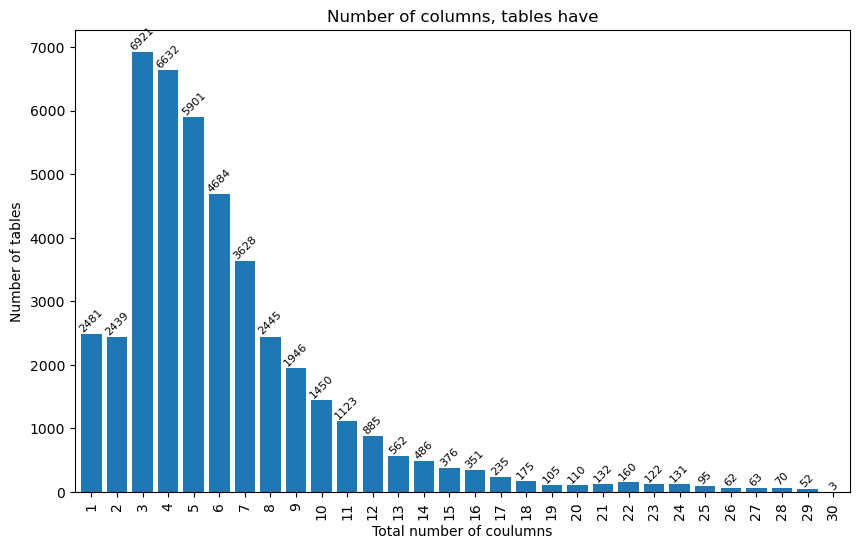

In [19]:
# setting a figure size
plt.figure(figsize=(10, 6))

# plotting the bar chart
ax = value_counts.plot(kind='bar', width=0.8)

# settting the labels and title
plt.xlabel('Total number of coulumns')
plt.ylabel('Number of tables')
plt.title('Number of columns, tables have')

# Add count values on top of each bar
for i, v in enumerate(value_counts):
    ax.text(i, v, str(v), ha='center', va='bottom', rotation=45, fontsize=8)

# displaying the chart
plt.show()

# # Print the value counts
# print("Value Counts:")
# print(value_counts)

In [21]:
# Access the column header and check its data type
column_header = df_train_5.columns[0]
data_type = df_train_5[column_header].dtype

print("Data type of column header:", data_type)

Data type of column header: object


#### Preparing the file dataset using which we can train a model 
* Henceforth it would be having two major column 1. data_value and 2. label 

In [22]:
# Path to the folder where the tables are stored
folder_path = 'dataset/Round2-SOTAB-CTA-Tables/'

# A column 'data_value' will work as a input dataset to our model
df_train_5['data_value'] = None

# Iterate over each row in the dataframe
for index, row in df_train_5.iterrows():
    table_name = row['table_name']
    column_name = row['column_index']
    
    # Check if the table file exists in the folder
    table_file_path = os.path.join(folder_path, table_name)  # Assuming the tables are stored as CSV files
    
    if os.path.isfile(table_file_path):
        # Load the table file into a dataframe
        table_df = pd.read_json(table_file_path, lines=True, compression='gzip')
        
        # Check if the column exists in the table dataframe
        if column_name in table_df.columns:
            # Fetch the column data
            column_data = table_df[column_name]
            
            # Assign the column data to the 'data_value' column in the original dataframe
            df_train_5.at[index, 'data_value'] = column_data.tolist()
            
            # Do something with the column data
            # For example, print the first 5 values
#             print(f"Table: {table_name}, Column: {column_name}")
#             print(column_data.head())
#             print()
        else:
            print(f"Column '{column_name}' does not exist in table '{table_name}'.")
    else:
        print(f"Table '{table_name}' does not exist in the folder.")



In [23]:
df_train_5

,table_name,column_index,label,data_value
0,Book_hytrol.com_September2020_CTA.json.gz,1,Book/description,"[A compilation of Hytrol products, including r..."
1,Book_krakencollectivebooks.com_September2020_C...,1,Book/description,[Stake Sauce is a serial novel from author RoA...
2,Book_shilka.uk_September2020_CTA.json.gz,1,Book/description,[This compendium edition brings together the c...
3,Book_mulhollandbooks.com_September2020_CTA.jso...,1,Book/description,[A woman returns home to find a stranger livin...
4,Book_kamaladevi.com_September2020_CTA.json.gz,0,Book/description,[KamalaDevi's Sacred Slut Sutras are a collect...
...,...,...,...,...
1195,JobPosting_crtcare.co.uk_September2020_CTA.jso...,4,workHours,"[Flexible hours available, Flexible hours avai..."
1196,JobPosting_sweetjobspnw.com_September2020_CTA....,5,workHours,"[schedule which may include nights, weekends a..."
1197,JobPosting_wholefoodsmarket.com_September2020_...,5,workHours,"[40 hours per week, 40 hours per week, 40 hour..."
1198,JobPosting_abbvie.com_September2020_CTA.json.gz,9,workHours,"[UNAVAILABLE, UNAVAILABLE, UNAVAILABLE, UNAVAI..."


In [24]:
df_train_5_ml = df_train_5[['label','data_value']]
df_train_5_ml

,label,data_value
0,Book/description,"[A compilation of Hytrol products, including r..."
1,Book/description,[Stake Sauce is a serial novel from author RoA...
2,Book/description,[This compendium edition brings together the c...
3,Book/description,[A woman returns home to find a stranger livin...
4,Book/description,[KamalaDevi's Sacred Slut Sutras are a collect...
...,...,...
1195,workHours,"[Flexible hours available, Flexible hours avai..."
1196,workHours,"[schedule which may include nights, weekends a..."
1197,workHours,"[40 hours per week, 40 hours per week, 40 hour..."
1198,workHours,"[UNAVAILABLE, UNAVAILABLE, UNAVAILABLE, UNAVAI..."


## Do some ML 

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [27]:
new_df = df_train_5_ml.explode('data_value', ignore_index=True).apply(pd.Series.explode)

In [28]:
new_df['label'].nunique()

80

In [29]:
unique_labels = new_df['label'].unique()
print(unique_labels)

['Book/description' 'Book/name' 'BookFormatType' 'Boolean' 'Brand'
 'CategoryCode' 'CoordinateAT' 'Country' 'CreativeWork'
 'CreativeWork/name' 'CreativeWorkSeries' 'Date' 'DateTime' 'DayOfWeek'
 'Distance' 'Duration' 'EducationalOccupationalCredential' 'Energy'
 'Event/description' 'Event/name' 'EventAttendanceModeEnumeration'
 'EventStatusType' 'GenderType' 'Hotel/description' 'Hotel/name'
 'IdentifierAT' 'ItemAvailability' 'ItemList' 'JobPosting/description'
 'JobPosting/name' 'Language' 'LocalBusiness/name'
 'LocationFeatureSpecification' 'Mass' 'MonetaryAmount'
 'Movie/description' 'Movie/name' 'Museum/name' 'MusicAlbum/name'
 'MusicArtistAT' 'MusicRecording/name' 'Number'
 'OccupationalExperienceRequirements' 'OfferItemCondition' 'Organization'
 'Person/name' 'Photograph' 'Place/name' 'PostalAddress'
 'Product/description' 'Product/name' 'ProductModel' 'QuantitativeValue'
 'Rating' 'Recipe/description' 'Recipe/name' 'Restaurant/name'
 'RestrictedDiet' 'Review' 'SportsEvent/name' 

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_df['data_value'], new_df['label'], test_size=0.2, stratify=new_df['label'], random_state=42)

In [31]:
print(y_train.shape)

(337632,)


In [32]:
# Convert X_train and X_test to lists of strings
X_train = [str(x) for x in X_train]
X_test = [str(x) for x in X_test]

# Create an instance of CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform the training and testing data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [33]:
# Create an instance of the Logistic Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train_vec, y_train)

C:\Users\Administrator\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [34]:
# Evaluate the model
accuracy = model.score(X_test_vec, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8523599658800114


In [35]:
# Make predictions on the test data
y_pred = model.predict(X_test_vec)

In [36]:
# Calculate precision, recall, and F1 score
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision_macro}")
print(f"Recall: {recall_macro}")
print(f"F1 score: {f1_macro}")

Precision: 0.8947857518322643
Recall: 0.735091011940905
F1 score: 0.7795637919922864


In [37]:
report = classification_report(y_test, y_pred)
print(report)

                                    precision    recall  f1-score   support

                  Book/description       0.90      0.85      0.87       233
                         Book/name       0.86      0.57      0.69       852
                    BookFormatType       0.99      0.98      0.99       684
                           Boolean       0.91      0.51      0.65       244
                             Brand       0.90      0.64      0.75       896
                      CategoryCode       0.98      0.98      0.98      1828
                      CoordinateAT       0.66      0.70      0.68       385
                           Country       0.95      0.92      0.93       616
                      CreativeWork       1.00      0.00      0.01       334
                 CreativeWork/name       0.91      0.77      0.83       722
                CreativeWorkSeries       0.86      0.79      0.82      1584
                              Date       0.81      0.79      0.80       106
           

### Preparing the submission files for the competition

In [82]:
df_test_4 = df_test[:]

In [83]:
df_test_4 

,table_name,column_index
0,CreativeWork_2agenten.com_September2020_CTA.js...,1
1,CreativeWork_biliranisland.com_September2020_C...,3
2,CreativeWork_biliranisland.com_September2020_C...,4
3,CreativeWork_biodiversitylibrary.org_September...,2
4,CreativeWork_bloominggreenflowers.co.uk_Septem...,3
...,...,...
1107,Product_badcattoys.com_September2020_CTA.json.gz,26
1108,Product_badcattoys.com_September2020_CTA.json.gz,27
1109,Product_badcattoys.com_September2020_CTA.json.gz,5
1110,SportsEvent_cuescore.com_September2020_CTA.jso...,1


In [84]:
# Path to the folder where the tables are stored
folder_path = 'dataset/Round2-SOTAB-CTA-Tables/'
# A column 'data_value' will work as a input dataset to our model
df_test_4['data_value'] = None

# Iterate over each row in the dataframe
for index, row in df_test_4.iterrows():
    table_name = row['table_name']
    column_name = row['column_index']
    
    # Check if the table file exists in the folder
    table_file_path = os.path.join(folder_path, table_name)  # Assuming the tables are stored as CSV files
    
    if os.path.isfile(table_file_path):
        # Load the table file into a dataframe
        table_df = pd.read_json(table_file_path, lines=True, compression='gzip')
        
        # Check if the column exists in the table dataframe
        if column_name in table_df.columns:
            # Fetch the column data
            column_data = table_df[column_name]
            
            # Assign the column data to the 'data_value' column in the original dataframe
            df_test_4.at[index, 'data_value'] = column_data.tolist()
            
            # Do something with the column data
            # For example, print the first 5 values
#             print(f"Table: {table_name}, Column: {column_name}")
#             print(column_data.head())
#             print()
        else:
            print(f"Column '{column_name}' does not exist in table '{table_name}'.")
    else:
        print(f"Table '{table_name}' does not exist in the folder.")

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21224\1498760386.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_4['data_value'] = None


In [86]:
print(df_test_4.iloc[0,0])
df_test_4

CreativeWork_2agenten.com_September2020_CTA.json.gz


,table_name,column_index,data_value
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,"[[JACOBIN MAGAZINE, PANDA EXPRESS RESTAURANTS,..."
1,CreativeWork_biliranisland.com_September2020_C...,3,"[None, Caibiran Jingle, 2ND MAYOR GERARD ROGER..."
2,CreativeWork_biliranisland.com_September2020_C...,4,"[None, Jalmz, Jalmz, Jalmz, None, Jalmz, Jalmz..."
3,CreativeWork_biodiversitylibrary.org_September...,2,"[English, English, English, None, English, Eng..."
4,CreativeWork_bloominggreenflowers.co.uk_Septem...,3,"[None, None, None, None, The Shed, The Shed, N..."
...,...,...,...
1107,Product_badcattoys.com_September2020_CTA.json.gz,26,"[2.5, 23.6, 3.0, 34.0, 3.9, nan, 6.25, 8.27, 6..."
1108,Product_badcattoys.com_September2020_CTA.json.gz,27,"[INH, INH, INH, INH, INH, None, INH, INH, INH,..."
1109,Product_badcattoys.com_September2020_CTA.json.gz,5,"[192959807547, UPCT60H, OMEGAHPL250, Folding D..."
1110,SportsEvent_cuescore.com_September2020_CTA.jso...,1,[Rack N Roll In-House Handicap 9 Ball Series 2...


In [87]:
# # Read a sample file and sources residing in it : File name and data residing in it. 
# file_path_gz = 'dataset/Round2-SOTAB-CTA-Tables/CreativeWork_2agenten.com_September2020_CTA.json.gz'  # Replace with the actual file path of your JSON file
# df = pd.read_json(file_path_gz, lines=True, compression='gzip')

In [88]:
df_test_4 = df_test_4.explode('data_value')

In [89]:
df_test_4

,table_name,column_index,data_value
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,"[JACOBIN MAGAZINE, PANDA EXPRESS RESTAURANTS, ..."
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,"[HANDSOME FRANK, AIRBNB MAGAZINE, DE BUITENKAN..."
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,"[DEVK, BAHN, WAGEN EINS MAGAZINE, LIBERAL MAGA..."
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,"[DEVIANNE, ROOSTER, BIG TOOL, SKINBIOTIC, HIGH..."
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,"[PERSONAL WORK, ABSOLUT VODKA, ACNE, BONAFYDE,..."
...,...,...,...
1111,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode
1111,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode
1111,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode
1111,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode


In [90]:
df_explosion = df_test_4.explode('data_value', ignore_index=True).apply(pd.Series.explode)

In [91]:
df_explosion

,table_name,column_index,data_value
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,JACOBIN MAGAZINE
1,CreativeWork_2agenten.com_September2020_CTA.js...,1,PANDA EXPRESS RESTAURANTS
2,CreativeWork_2agenten.com_September2020_CTA.js...,1,STARBUCKS
3,CreativeWork_2agenten.com_September2020_CTA.js...,1,CB2 FURNITURE
4,CreativeWork_2agenten.com_September2020_CTA.js...,1,L'OCCITANE
...,...,...,...
652886,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode
652887,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode
652888,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode
652889,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode


In [92]:
# Count the NaN values in each column
nan_count_column = df_explosion.isna().sum()
print(nan_count_column)

table_name          0
column_index        0
data_value      65222
dtype: int64


In [93]:
X_test_test = df_explosion['data_value']
print(type(X_test_test))
print(X_test_test[1])

<class 'pandas.core.series.Series'>
PANDA EXPRESS RESTAURANTS


In [94]:
# Convert X_train and X_test to lists of strings
X_test_test = [str(x) for x in X_test_test]


# Fit the vectorizer on the training data and transform the training and testing data
X_test_test_vec = vectorizer.transform(X_test_test)

In [95]:
print(X_test_test_vec.shape)
print(X_test_vec.shape)
print(X_train_vec.shape)

(653007, 81071)
(316835, 81071)
(1267339, 81071)


In [96]:
# Make predictions on the test_test data
y_pred_test = model.predict(X_test_test_vec)

In [97]:
print(y_pred_test.shape)
print(type(y_pred_test))

(653007,)
<class 'numpy.ndarray'>


In [99]:
# Convert the NumPy array to a DataFrame
y_pred_test_df = pd.DataFrame({'label': y_pred_test})

# Reset the index of df_explosion
df_explosion.reset_index(drop=True, inplace=True)

# Reset the index of y_pred_test_df
y_pred_test_df.reset_index(drop=True, inplace=True)

# Concatenate the original DataFrame and the array DataFrame along the column axis
PAAV_SCH_R2CTA = pd.concat([df_explosion, y_pred_test_df], axis=1)

In [100]:
PAAV_SCH_R2CTA 

,table_name,column_index,data_value,label
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,JACOBIN MAGAZINE,LocationFeatureSpecification
1,CreativeWork_2agenten.com_September2020_CTA.js...,1,PANDA EXPRESS RESTAURANTS,LocationFeatureSpecification
2,CreativeWork_2agenten.com_September2020_CTA.js...,1,STARBUCKS,LocationFeatureSpecification
3,CreativeWork_2agenten.com_September2020_CTA.js...,1,CB2 FURNITURE,LocationFeatureSpecification
4,CreativeWork_2agenten.com_September2020_CTA.js...,1,L'OCCITANE,LocationFeatureSpecification
...,...,...,...,...
653002,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode,EventAttendanceModeEnumeration
653003,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode,EventAttendanceModeEnumeration
653004,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode,EventAttendanceModeEnumeration
653005,SportsEvent_cuescore.com_September2020_CTA.jso...,3,OfflineEventAttendanceMode,EventAttendanceModeEnumeration


In [101]:
PAAV_SCH_R2CTA_SUB = PAAV_SCH_R2CTA[['table_name','column_index', 'label']]
PAAV_SCH_R2CTA_SUB

,table_name,column_index,label
0,CreativeWork_2agenten.com_September2020_CTA.js...,1,LocationFeatureSpecification
1,CreativeWork_2agenten.com_September2020_CTA.js...,1,LocationFeatureSpecification
2,CreativeWork_2agenten.com_September2020_CTA.js...,1,LocationFeatureSpecification
3,CreativeWork_2agenten.com_September2020_CTA.js...,1,LocationFeatureSpecification
4,CreativeWork_2agenten.com_September2020_CTA.js...,1,LocationFeatureSpecification
...,...,...,...
653002,SportsEvent_cuescore.com_September2020_CTA.jso...,3,EventAttendanceModeEnumeration
653003,SportsEvent_cuescore.com_September2020_CTA.jso...,3,EventAttendanceModeEnumeration
653004,SportsEvent_cuescore.com_September2020_CTA.jso...,3,EventAttendanceModeEnumeration
653005,SportsEvent_cuescore.com_September2020_CTA.jso...,3,EventAttendanceModeEnumeration


In [102]:
# Group by 'table_name' and 'column_index', and find the label that occurred the maximum times
PAAV_SCH_R2CTA_SUB = PAAV_SCH_R2CTA_SUB.groupby(['table_name', 'column_index'])['label'].apply(lambda x: x.value_counts().idxmax()).reset_index()

In [103]:
PAAV_SCH_R2CTA_SUB.head()

,table_name,column_index,label
0,Book_artforum.sk_September2020_CTA.json.gz,0,LocationFeatureSpecification
1,Book_artforum.sk_September2020_CTA.json.gz,1,Book/description
2,Book_artforum.sk_September2020_CTA.json.gz,5,OfferItemCondition
3,Book_artforum.sk_September2020_CTA.json.gz,6,ItemAvailability
4,Book_auth-e83.co.uk_September2020_CTA.json.gz,2,BookFormatType


In [105]:
df_test.head()

,table_name,column_index
0,CreativeWork_2agenten.com_September2020_CTA.js...,1
1,CreativeWork_biliranisland.com_September2020_C...,3
2,CreativeWork_biliranisland.com_September2020_C...,4
3,CreativeWork_biodiversitylibrary.org_September...,2
4,CreativeWork_bloominggreenflowers.co.uk_Septem...,3


In [107]:
# Get the unique values of the column in both DataFrames
unique_values_df_test = set(df_test['table_name'])
unique_values_PAAV_SCH_R2CTA_SUB = set(PAAV_SCH_R2CTA_SUB['table_name'])

# Check if the unique values are the same
if unique_values_df_test == unique_values_PAAV_SCH_R2CTA_SUB:
    print("The DataFrames have the same set of values in the 'table_name' column.")
else:
    print("The DataFrames do not have the same set of values in the 'table_name' column.")
    
    
# Checking the shape of the file 
print(f"The shpae of the generated file is :{PAAV_SCH_R2CTA_SUB.shape} ")    

The DataFrames have the same set of values in the 'table_name' column.
The shpae of the generated file is :(1112, 3) 


(1112, 3)


In [108]:
# Save the DataFrame as a CSV file
PAAV_SCH_R2CTA_SUB.to_csv('DREIFLUSS_sotab_cta_test_targets_round2_R2-SOTAB-CTA-SCH.csv', index=False)

In [54]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification

# Define the BERT model and tokenizer
model_name = 'bert-base-uncased'
num_labels = 80
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)

# Preprocess the input data
def preprocess_data(data, labels):
    input_ids = []
    attention_masks = []
    for text in data:
        encoded_text = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=128,  # Adjust as needed
            padding='max_length',
            truncation=True,
            return_attention_mask=True
        )
        input_ids.append(encoded_text['input_ids'])
        attention_masks.append(encoded_text['attention_mask'])
    
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    return input_ids, attention_masks, labels

# Example input data
data = [
    "This is the first text.",
    "Another example text.",
    "And a third text."
]
labels = [1, 2, 3]  # Example labels, adjust as needed

# Preprocess the input data
input_ids, attention_masks, labels = preprocess_data(data, labels)

# Create DataLoader for batching
batch_size = 2
dataset = torch.utils.data.TensorDataset(input_ids, attention_masks, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set up optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()

# Training loop
epochs = 3  # Adjust as needed
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.train()

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    for batch_idx, (input_ids_batch, attention_masks_batch, labels_batch) in enumerate(dataloader):
        input_ids_batch = input_ids_batch.to(device)
        attention_masks_batch = attention_masks_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids_batch, attention_mask=attention_masks_batch, labels=labels_batch)
        
        loss = outputs.loss
        logits = outputs.logits
        
        loss.backward()
        optimizer.step()
        
        print(f"Batch {batch_idx + 1}/{len(dataloader)} - Loss: {loss.item()}")



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/3
Batch 1/2 - Loss: 4.245355606079102
Batch 2/2 - Loss: 3.5834102630615234
Epoch 2/3
Batch 1/2 - Loss: 4.132392406463623
Batch 2/2 - Loss: 3.7615251541137695
Epoch 3/3
Batch 1/2 - Loss: 3.659687042236328
Batch 2/2 - Loss: 4.410285949707031


In [55]:

# Inference
model.eval()

# Example input for inference
input_text = "This is a test text."

# Preprocess the input for inference
input_ids, attention_mask, _ = preprocess_data([input_text], [0])
input_ids = input_ids.to(device)
attention_mask = attention_mask.to(device)

# Perform inference
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits

# Get predicted label
predicted_label = torch.argmax(logits, dim=1).item()
print(f"Predicted label: {predicted_label}")

Predicted label: 3


## Checking scores with Bert

In [24]:
from transformers import BertTokenizer, BertModel
import torch
from scipy.spatial.distance import cosine
import itertools

In [3]:
# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
# Input words
word1 = "apple"
word2 = "banana"
word = [word1, word2]

In [33]:
# Tokenize and convert to BERT input format
# tokens = tokenizer.encode_plus(word1, word2, add_special_tokens=True, return_tensors='pt')
tokens = tokenizer(word, padding=True, truncation=True, return_tensors='pt')
input_ids = tokens['input_ids']
attention_mask = tokens['attention_mask']

In [34]:
print(tokens)
print(input_ids)
print(attention_mask)

{'input_ids': tensor([[  101,  6207,   102],
        [  101, 15212,   102]]), 'token_type_ids': tensor([[0, 0, 0],
        [0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1]])}
tensor([[  101,  6207,   102],
        [  101, 15212,   102]])
tensor([[1, 1, 1],
        [1, 1, 1]])


In [35]:
# Obtain BERT embeddings
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state.mean(dim=1)  # Average the embeddings across tokens

In [36]:
# Obtain BERT embeddings
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state[:, 1:-1, :].mean(dim=1)  
    # Average the embeddings across tokens (excluding special tokens)

In [37]:
print(embeddings.shape)
print(type(outputs))

torch.Size([2, 768])
<class 'transformers.modeling_outputs.BaseModelOutputWithPoolingAndCrossAttentions'>


In [38]:
# Check if there is only one embedding
if embeddings.ndim == 1:
    embeddings = embeddings.unsqueeze(0)

In [40]:
# Calculate cosine similarity distance
embedding1 = embeddings[0].numpy()
embedding2 = embeddings[1].numpy()
distance = cosine(embedding1, embedding2)

In [41]:
print("Distance:", distance)

Distance: 0.17003083229064941


In [25]:
# Input words
words = ["apple", "banana", "orange"]  # Add or remove words as needed

# Tokenize and convert to BERT input format
inputs = tokenizer(words, padding=True, truncation=True, return_tensors='pt')
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Obtain BERT embeddings
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
    embeddings = outputs.last_hidden_state[:, 1:-1, :].mean(dim=1)  # Average the embeddings across tokens (excluding special tokens)

# Calculate cosine similarity distances between pairwise embeddings
combinations = list(itertools.combinations(range(len(words)), 2))
distances = []
for i, j in combinations:
    embedding1 = embeddings[i].numpy()
    embedding2 = embeddings[j].numpy()
    distance = cosine(embedding1, embedding2)
    distances.append(distance)

# Print the distances
for (i, j), distance in zip(combinations, distances):
    print(f"Distance between '{words[i]}' and '{words[j]}': {distance}")

Distance between 'apple' and 'banana': 0.17003083229064941
Distance between 'apple' and 'orange': 0.24633169174194336
Distance between 'banana' and 'orange': 0.1570427417755127


In [26]:
print(embeddings.shape)

torch.Size([3, 768])


In [29]:
print(inputs)

{'input_ids': tensor([[  101,  6207,   102],
        [  101, 15212,   102],
        [  101,  4589,   102]]), 'token_type_ids': tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]])}


In [46]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [27]:
# Split the data into training and testing sets use new_df dataframe
train_df, test_df = train_test_split(new_df, test_size=0.2, random_state=42)

# Define the label and data columns
label_column = 'label'
data_column = 'data_value'

In [28]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [33]:
# Tokenize the text data
def tokenize_data(text_data):
    tokenized_data = tokenizer.batch_encode_plus(
        text_data.apply(lambda x: x[0] if isinstance(x, list) else str(x)),
        add_special_tokens=True,
        padding='longest',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokenized_data

In [36]:
# Prepare the training data
train_data = tokenize_data(train_df[data_column])

# Encode the labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df[label_column])

# Convert the labels to a PyTorch tensor
train_labels = torch.tensor(train_labels)

# Prepare the testing data
test_data = tokenize_data(test_df[data_column])
test_labels = label_encoder.transform(test_df[label_column])
test_labels = torch.tensor(test_labels)

In [53]:
type(train_labels)
print(train_labels.size())


torch.Size([289469])


In [37]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=80)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [43]:
# Set up the optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

C:\Users\Administrator\anaconda3\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [49]:
# Fine-tune BERT
model.train()
train_batch_size = 2
epochs = 2

In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    for i in range(0, len(train_data['input_ids']), train_batch_size):
        optimizer.zero_grad()
        
        input_ids = train_data['input_ids'][i:i+train_batch_size].squeeze()
        attention_mask = train_data['attention_mask'][i:i+train_batch_size].squeeze()
        labels = train_labels[i:i+train_batch_size].long()  # Convert labels to Long data type
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        print(f"Batch {i // train_batch_size + 1}/{len(train_data['input_ids']) // train_batch_size}")

In [ ]:
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    progress_bar = tqdm(range(0, len(train_data['input_ids']), train_batch_size), total=len(train_data['input_ids']) // train_batch_size)
    
    for batch_idx in progress_bar:
        optimizer.zero_grad()
        
        input_ids = train_data['input_ids'][batch_idx:batch_idx+train_batch_size].squeeze()
        attention_mask = train_data['attention_mask'][batch_idx:batch_idx+train_batch_size].squeeze()
        labels = train_labels[batch_idx:batch_idx+train_batch_size].long()  # Convert labels to Long data type
        
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        progress_bar.set_description(f"Batch {batch_idx // train_batch_size + 1}/{len(train_data['input_ids']) // train_batch_size}")
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{outputs.logits.argmax(dim=1).eq(labels).sum().item() / labels.size(0):.4f}")

In [ ]:
# Evaluate the model
model.eval()

In [ ]:
with torch.no_grad():
    input_ids = test_data['input_ids'].squeeze()
    attention_mask = test_data['attention_mask'].squeeze()
    
    outputs = model(input_ids, attention_mask=attention_mask)
    
    predicted_labels = torch.argmax(outputs.logits, dim=1).numpy()

In [ ]:
# Generate classification report
target_names = df[label_column].unique().tolist()
report = classification_report(test_labels, predicted_labels, target_names=target_names)
print(report)